In [145]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tqdm
%matplotlib inline

In [2]:
random_seed = 2147483647

In [3]:
words = open("names.txt", "r").read().splitlines()

In [4]:
words[:3]

['emma', 'olivia', 'ava']

Create character to index and reverse mapping dictionaries.

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Bigram Model

Steps involved - 

1. Create training data - create `xs` and `ys`.
2. One hot encode the `xs`. This gives `n` features for each `x`. We would want the network to make predictions for each one of the possible `y`s. Hence the number of outputs would also be `n`.
3. Instantiate weights `w`, of the size `n x n`
4. Matrix multiply `xs` and `w` to get `y_pred` predictions.
5. `y_pred`  can be considered natural log of counts. We can do an exponent of this and then average to get probabilities which are in the range 0 and 1, and all prediction for a particular `x` add up to `1`. This is called `cross_entropy` loss.
6. Set gradient of parameters (`w`) to zero.
7. Perform backward pass on the loss function.
8. Update `w` based on the gradients and learning rate.
9. Recalculate loss until satisfied.
10. Decay the learning rate once it stops improving. Dividing by 10 is the usual practice.


Visualise word counts

In [ ]:
N = torch.zeros((27,27), dtype=torch.int32)

In [ ]:
for w in words:
    w = '.' + w + '.'
    for ch1, ch2 in zip(w,w[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

In [ ]:
plt.figure(figsize = (13,13))
plt.imshow(N, cmap = 'Blues')
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        counts=plt.text(j, i, N[i, j].item(), ha='center', va='bottom', fontsize = 8 )
        counts.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

        
        label=plt.text(j, i, f'{itos[i]}{itos[j]}', ha='center', va='top', fontsize = 8)
        label.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.axis('off')

Prepare Training data

In [ ]:
xs, ys = [], []
for w in words:
    w = '.' + w + '.'
    for ch1, ch2 in zip(w, w[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(f'{xs=}, \n{ys=}')
possible_inputs = len(stoi)
possible_outputs = len(stoi)


One hot encode `xs`

In [ ]:
xenc = F.one_hot(xs, num_classes = possible_outputs).float()
xenc.shape

#### Train NN

In [ ]:
# Instantiate weights

g = torch.Generator().manual_seed(random_seed)
w = torch.randn((possible_inputs, possible_outputs), generator = g, requires_grad = True)

In [ ]:
for _ in range(100):
    
    # Forward pass
    
    logits = xenc @ w
    counts = logits.exp()
    probs = counts/ counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    
    # BackPropagation
    
    w.grad = None
    loss.backward()
    
    # Update weights
    
    w.data += -40 * w.grad

print(f'{loss=}')

#### Make predictions

In [ ]:
g = torch.Generator().manual_seed(random_seed)
P = w.exp()/ w.exp().sum(1, keepdim=True)
preds = []
for _ in range(5):
    ix = 0
    out = ''
    while True:
        ix = torch.multinomial(P[ix], num_samples = 1, generator=g, replacement = True).item()
        out += itos[ix]
        if ix == 0:
            break

    preds.append(out)

preds
    

### Trigram Model

Create Training Data

In [6]:
block_size = 3 # How many characters we take to predict the next character.
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for char in w + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        # print(f'{"".join([itos[i] for i in context])} ---> {char}')
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [163]:
block_size = 3
def build_dataset(words, block_size = block_size):
    # How many characters we take to predict the next character.
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for char in w + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            # print(f'{"".join([itos[i] for i in context])} ---> {char}')
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

Split to train validation and test sets.

In [164]:
import random

random.seed(random_seed)
random.shuffle(words)
n1 = int(0.8*(len(words)))
n2 = int(0.9*(len(words)))

Xtrn, Ytrn = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182632, 3]) torch.Size([182632])
torch.Size([22690, 3]) torch.Size([22690])
torch.Size([22824, 3]) torch.Size([22824])


#### Forward Pass

In [155]:
num_emb = 2
num_out1 = 6
g = torch.Generator().manual_seed(random_seed)
C = torch.randn((27,num_emb), generator = g) # possible outputs, number of embeddings.

##### Pytorch indexing 101

Indexing C is same as multiplying one hot with C.

1. The first step of our model can thus be considered equivalent to a layer without any non-linearity.
2. C being the weights and one hot encoded character being the input.
3. The number of neurons would be same as the number of outputs, i.e. 2 if C has 2 columns.


In [93]:
C[5]

tensor([-0.4713,  0.7868])

In [94]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4713,  0.7868])

In [95]:
X.shape

torch.Size([228146, 3])

In [96]:
C[X].shape

torch.Size([228146, 3, 2])

In [97]:
X[13,2]

tensor(1)

In [98]:
C[X][13,2]

tensor([-0.0274, -1.1008])

In [ ]:
C[1]

##### create embedding matrix

In [ ]:
emb = C[X]
emb.shape

Initialise weights for the non-linear layer

In [ ]:
w1 = torch.randn((block_size * num_emb, num_out1), generator = g)
b1 = torch.randn((num_out), generator = g)

In [ ]:
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)

In [ ]:
h.shape

In [ ]:
w2 = torch.randn((num_out1, 27), generator = g)
b2 = torch.randn((27), generator = g)

In [ ]:
logits = h @ w2 + b2

In [ ]:
logits.shape

#### Calculate Loss 

In [ ]:
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)

In [ ]:
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()

In [ ]:
loss

#### Combined model

In [ ]:
# ------------ rewriting everything ------------

In [165]:
Xtrn.shape, Ytrn.shape

(torch.Size([182632, 3]), torch.Size([182632]))

first Layer

In [219]:
num_emb = 10
num_out1 = 200
minibatch_size = 32

lr = 10**-0.5

In [220]:
g = torch.Generator().manual_seed(random_seed)
C = torch.randn((27,num_emb), generator = g) # possible outputs, number of embeddings.
w1 = torch.randn((block_size * num_emb, num_out1), generator = g)
b1 = torch.randn((num_out1), generator = g)
w2 = torch.randn((num_out1, 27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, w1, b1, w2, b2]

In [221]:
sum(p.nelement() for p in parameters)

11897

In [222]:
for p in parameters:
    p.requires_grad=True

##### LR identification

In [170]:
niter = 1000
lre = torch.linspace(-3,1,niter)
lrs = 10**lre
lri = []
lossi = []

for i in range(niter):

    # minibatch construct
    ix = torch.randint(0,Xtrn.shape[0], size = (minibatch_size, ), generator = g)
    
    #forward pass 
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
    logits = h @ w2 + b2
    
    loss = F.cross_entropy(logits, Ytrn[ix])
    
    # backpropagation - backward pass
    
    for p in parameters:
        p.grad = None 
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    lri.append(lre[i])
    lossi.append(loss.data)
    
print(f'{loss=}')

loss=tensor(96.9301, grad_fn=<NllLossBackward0>)


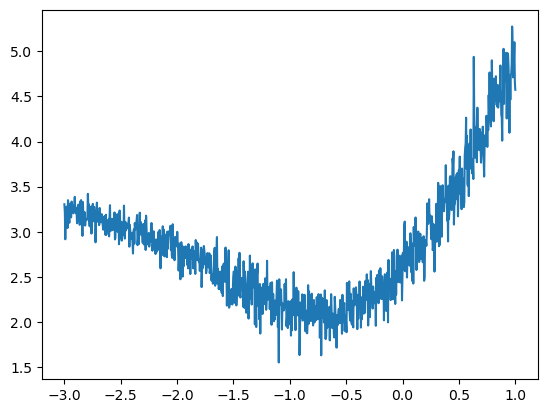

In [171]:
plt.plot(lri, torch.log(torch.tensor(lossi)))

##### NN iterations

In [223]:
niter = 200000
for i in tqdm.tqdm(range(1,niter)): # starting from 1, to prevent learning rate decay at i == 0.

    # minibatch construct
    ix = torch.randint(0,Xtrn.shape[0], size = (minibatch_size, ), generator = g)
    
    #forward pass 
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
    logits = h @ w2 + b2
    
    loss = F.cross_entropy(logits, Ytrn[ix])
    
    # backpropagation - backward pass
    if i % 70000 == 0: # learning rate decay after every 70k iterations.
        lr /=10.0
        print(f'decaying lr to {lr=}')
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
    
print(f'{loss=}')

 35%|██████████████████████▏                                        | 70401/199999 [00:20<00:40, 3189.63it/s]

decaying lr to lr=0.03162277660168379


 70%|███████████████████████████████████████████▌                  | 140662/199999 [00:41<00:17, 3398.63it/s]

decaying lr to lr=0.003162277660168379


100%|██████████████████████████████████████████████████████████████| 199999/199999 [00:59<00:00, 3359.10it/s]

loss=tensor(2.0676, grad_fn=<NllLossBackward0>)


In [224]:
emb = C[Xtrn]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ytrn)
loss

tensor(2.0803, grad_fn=<NllLossBackward0>)

In [225]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1415, grad_fn=<NllLossBackward0>)

<mark>Beating Andrej Karpathy's notebook by training more rounds and further decaying the learning rate.</mark>

We are likely overfitting here, since the training and validation performance is afar. Will need to track perforamnce on dev to see if the loss starts increasing on the dev set to be sure. 

As we know from Jeremy Howard's lectures, Overfitting is when the validation data's performance starts deteriorating and not when the train and validation perforamnce difference starts increasing. Our sole objective is to have a high performance on the validation dataset and we should only be concerned about the score there. The training  dataset score could be avoided completely.

In [227]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1562, grad_fn=<NllLossBackward0>)

## Generating new names with the model

In [232]:
n = 20
# g = torch.Generator().manual_seed(random_seed)
for _ in range(n):
    out = []
    context = [0]*block_size
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1,30) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g, replacement = True).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0 :
            break
    print(''.join(out))

caine.
adeladeli.
aarous.
malon.
lavlokiel.
erick.
maza.
amayonni.
mondi.
alomina.
keen.
djyanny.
aria.
edrewkendin.
daon.
iya.
dyeti.
kazlei.
usncenzy.
jadenklynn.


## Further improving the model performance. 

### M1 - Add more layers to the nn.

In [302]:
block_size = 3
nex = 10
num_out = 100
ney = 10

minibatch_size = 32

lr = 10**-0.25

In [303]:
g = torch.Generator().manual_seed(random_seed)
Cx = torch.randn((27,nex), generator = g) # possible outputs, number of embeddings.
w1 = torch.randn((block_size * nex, num_out), generator = g)
b1 = torch.randn((num_out), generator = g)
w2 = torch.randn((num_out, ney), generator = g)
b2 = torch.randn((ney), generator = g)
Cy = torch.randn((ney, 27), generator = g)
parameters = [Cx, w1, b1, w2, b2, Cy]

In [304]:
sum(p.nelement() for p in parameters)

4650

In [296]:
for p in parameters:
    p.requires_grad=True

##### LR idnetification

In [277]:
niter = 1000
lre = torch.linspace(-3,1,niter)
lrs = 10**lre
lri = []
lossi = []

for i in range(niter):

    # minibatch construct
    ix = torch.randint(0,Xtrn.shape[0], size = (minibatch_size, ), generator = g)
    
    #forward pass 
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
    h2 = torch.tanh(h @ w2 + b2)
    logits = h2 @ w3 + b3
    
    loss = F.cross_entropy(logits, Ytrn[ix])
    
    # backpropagation - backward pass
    
    for p in parameters:
        p.grad = None 
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    lri.append(lre[i])
    lossi.append(loss.data)
    
print(f'{loss=}')

loss=tensor(40.8438, grad_fn=<NllLossBackward0>)


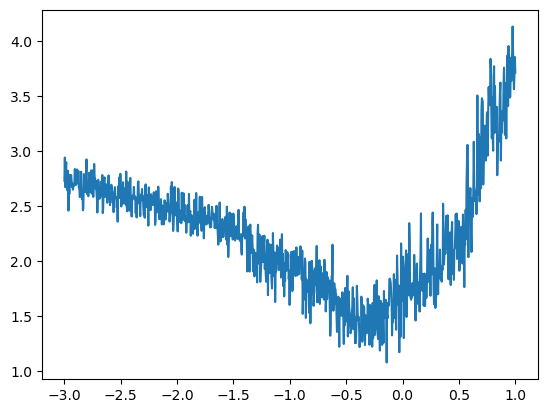

In [278]:
plt.plot(lri, torch.log(torch.tensor(lossi)))

##### NN iterations

In [297]:
niter = 200000
lossi = []
for i in tqdm.tqdm(range(1,niter)): # starting from 1, to prevent learning rate decay at i == 0.

    # minibatch construct
    ix = torch.randint(0,Xtrn.shape[0], size = (minibatch_size, ), generator = g)
    
    #forward pass 
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
    h2 = torch.tanh(h @ w2 + b2)
    logits = h2 @ w3 + b3
    
    loss = F.cross_entropy(logits, Ytrn[ix])
    
    # backpropagation - backward pass
    if i % 50000 == 0: # learning rate decay after every 70k iterations.
        lr /=10.0
        print(f'decaying lr to {lr=}')
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.data)
    
print(f'{loss=}')

 25%|███████████████▉                                               | 50612/199999 [00:14<00:36, 4063.81it/s]

decaying lr to lr=0.056234132519034905


 50%|███████████████████████████████▏                              | 100445/199999 [00:26<00:24, 4118.34it/s]

decaying lr to lr=0.00562341325190349


 75%|██████████████████████████████████████████████▋               | 150672/199999 [00:39<00:12, 4067.18it/s]

decaying lr to lr=0.000562341325190349


100%|██████████████████████████████████████████████████████████████| 199999/199999 [00:51<00:00, 3882.15it/s]

loss=tensor(2.1503, grad_fn=<NllLossBackward0>)


In [298]:
emb = C[Xtrn]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
h2 = torch.tanh(h @ w2 + b2)
logits = h2@w3 + b3
loss = F.cross_entropy(logits, Ytrn)
loss

tensor(2.1604, grad_fn=<NllLossBackward0>)

In [299]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
h2 = torch.tanh(h @ w2 + b2)
logits = h2@w3 + b3
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1911, grad_fn=<NllLossBackward0>)

### M2 - Energy function as described in the paper.

Andrej suggested trying improvements suggested in the paper to further improve the performance. One such suggestion was to have embeddings for the outputs as well, similar to what we had to for the inputs.

Lets try to implement this.

In [305]:
block_size = 3
nex = 10
num_out = 100
ney = 10

minibatch_size = 32

lr = 10**-0.25

In [308]:
g = torch.Generator().manual_seed(random_seed)
Cx = torch.randn((27,nex), generator = g) # possible outputs, number of embeddings.
w1 = torch.randn((block_size * nex, num_out), generator = g)
b1 = torch.randn((num_out), generator = g)
w2 = torch.randn((num_out, ney), generator = g)
b2 = torch.randn((ney), generator = g)
Cy = torch.transpose(Cx, 0, 1)
parameters = [Cx, w1, b1, w2, b2, Cy]

In [304]:
sum(p.nelement() for p in parameters)

4650

In [296]:
for p in parameters:
    p.requires_grad=True

##### LR idnetification

In [277]:
niter = 1000
lre = torch.linspace(-3,1,niter)
lrs = 10**lre
lri = []
lossi = []

for i in range(niter):

    # minibatch construct
    ix = torch.randint(0,Xtrn.shape[0], size = (minibatch_size, ), generator = g)
    
    #forward pass 
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
    h2 = torch.tanh(h @ w2 + b2)
    logits = h2 @ w3 + b3
    
    loss = F.cross_entropy(logits, Ytrn[ix])
    
    # backpropagation - backward pass
    
    for p in parameters:
        p.grad = None 
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    lri.append(lre[i])
    lossi.append(loss.data)
    
print(f'{loss=}')

loss=tensor(40.8438, grad_fn=<NllLossBackward0>)


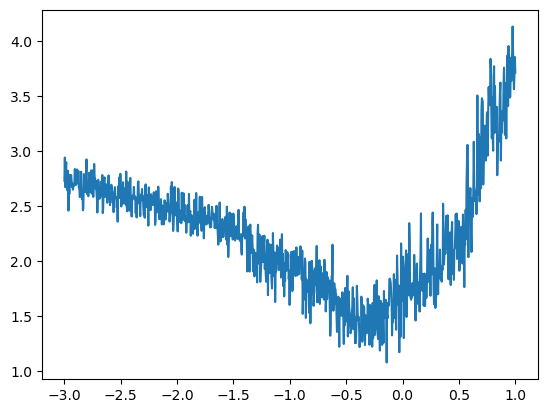

In [278]:
plt.plot(lri, torch.log(torch.tensor(lossi)))

##### NN iterations

In [297]:
niter = 200000
lossi = []
for i in tqdm.tqdm(range(1,niter)): # starting from 1, to prevent learning rate decay at i == 0.

    # minibatch construct
    ix = torch.randint(0,Xtrn.shape[0], size = (minibatch_size, ), generator = g)
    
    #forward pass 
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
    h2 = torch.tanh(h @ w2 + b2)
    logits = h2 @ w3 + b3
    
    loss = F.cross_entropy(logits, Ytrn[ix])
    
    # backpropagation - backward pass
    if i % 50000 == 0: # learning rate decay after every 70k iterations.
        lr /=10.0
        print(f'decaying lr to {lr=}')
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.data)
    
print(f'{loss=}')

 25%|███████████████▉                                               | 50612/199999 [00:14<00:36, 4063.81it/s]

decaying lr to lr=0.056234132519034905


 50%|███████████████████████████████▏                              | 100445/199999 [00:26<00:24, 4118.34it/s]

decaying lr to lr=0.00562341325190349


 75%|██████████████████████████████████████████████▋               | 150672/199999 [00:39<00:12, 4067.18it/s]

decaying lr to lr=0.000562341325190349


100%|██████████████████████████████████████████████████████████████| 199999/199999 [00:51<00:00, 3882.15it/s]

loss=tensor(2.1503, grad_fn=<NllLossBackward0>)


In [298]:
emb = C[Xtrn]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
h2 = torch.tanh(h @ w2 + b2)
logits = h2@w3 + b3
loss = F.cross_entropy(logits, Ytrn)
loss

tensor(2.1604, grad_fn=<NllLossBackward0>)

In [299]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, block_size * num_emb) @ w1 + b1)
h2 = torch.tanh(h @ w2 + b2)
logits = h2@w3 + b3
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1911, grad_fn=<NllLossBackward0>)

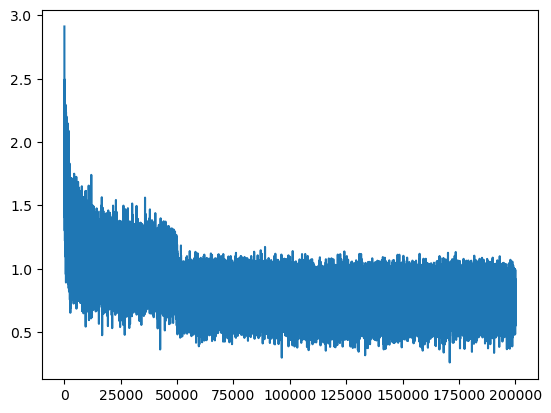

In [315]:
plt.plot(torch.arange(len(lossi)), torch.log(torch.tensor(lossi)))

In [ ]:
k